In this demo, we will build a video to searchable transcript pipeline using pixeltable primitives and openAI whisper. 
Along the way, we demonstrate how building this pipeline and inspecting the intermediate data is made easy by pixeltable, and how
pixeltable makes it easy to add more data and explore its results.

1) Ingests video
2) Extract the corresponding audio
3) Transcribe audio to text using openAI whisper
4) Build a semantic index based on sentence_transformers text embeddings

Once this pre-processing pipeline is built, we show how we can
5) Search the extracted data at a sentence granularity.
6) And how the pipeline is run and and data outputs are kept up to date when adding new videos, quickly letting us explore how our pipeline behaves with new data, and making any new videos searchable within an instant.

In [1]:
%pip install git+https://github.com/ytdl-org/youtube-dl

  Cloning https://github.com/ytdl-org/youtube-dl to /private/var/folders/8v/d886z5j13dsctyjpw29t7y480000gn/T/pip-req-build-ljze0xi6
  Running command git clone --filter=blob:none --quiet https://github.com/ytdl-org/youtube-dl /private/var/folders/8v/d886z5j13dsctyjpw29t7y480000gn/T/pip-req-build-ljze0xi6


  Resolved https://github.com/ytdl-org/youtube-dl to commit a08f2b7e4567cdc50c0614ee0a4ffdff49b8b6e6


  Preparing metadata (setup.py) ... -

 done


Note: you may need to restart the kernel to use updated packages.


In [2]:
%%bash
# check the right python is being used (same as kernel python)
# which python
# which youtube-dl
mkdir -p sample_videos
cd sample_videos
youtube-dl 'https://www.youtube.com/watch?v=YwWtDSponlc&ab_channel=CNBCTelevision'
youtube-dl 'https://www.youtube.com/watch?v=L9Tyb_ycRfU&ab_channel=CNBCTelevision'
youtube-dl 'https://www.youtube.com/watch?v=0wJqgHSfYi0&ab_channel=CNBCTelevision'

/Users/orm/mambaforge/envs/pixeltable_39/bin/python


/Users/orm/mambaforge/envs/pixeltable_39/bin/youtube-dl


/Users/orm/mambaforge/envs/pixeltable_39/bin/youtube-dl


[youtube] YwWtDSponlc: Downloading webpage


[download] Right now you want to be invested in companies that don't cater to the consumer, says Jim Cramer-YwWtDSponlc.mp4 has already been downloaded and merged


[youtube] L9Tyb_ycRfU: Downloading webpage


[download] Jim Cramer looks at how the Fed minutes spooked the markets today-L9Tyb_ycRfU.mp4 has already been downloaded and merged


[youtube] 0wJqgHSfYi0: Downloading webpage


[download] Snowflake CEO joins Jim Cramer after earnings report drives stock higher-0wJqgHSfYi0.mp4 has already been downloaded and merged


In [8]:
import pathlib
import pixeltable as pxt

In [13]:
pxt.create_dir('transcription_demo', ignore_errors=True)

In [14]:
pxt.drop_table('transcription_demo.sentence_view', ignore_errors=True)
pxt.drop_table('transcription_demo.video_table', ignore_errors=True)
video_table = pxt.create_table('transcription_demo.video_table', {'video': pxt.VideoType()},)

Created table `video_table`.


In [15]:
paths = [str(pathlib.Path(p).absolute()) for p in pathlib.Path('./sample_videos/').iterdir()]
video_table.insert([{'video': video_path} for video_path in paths[:1] ])

Inserting rows into `video_table`: 1 rows [00:00, 673.89 rows/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [16]:
from pixeltable.functions.video import get_metadata, extract_audio
from pixeltable.functions import openai

In [17]:
video_table.add_column(audio=extract_audio(video_table.video, format='mp3'))

Computing cells:   0%|                                                    | 0/1 [00:00<?, ? cells/s]

Computing cells: 100%|████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/ cells]
Added 1 column value with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=1, num_excs=0, updated_cols=[], cols_with_excs=[])

video,audio
,

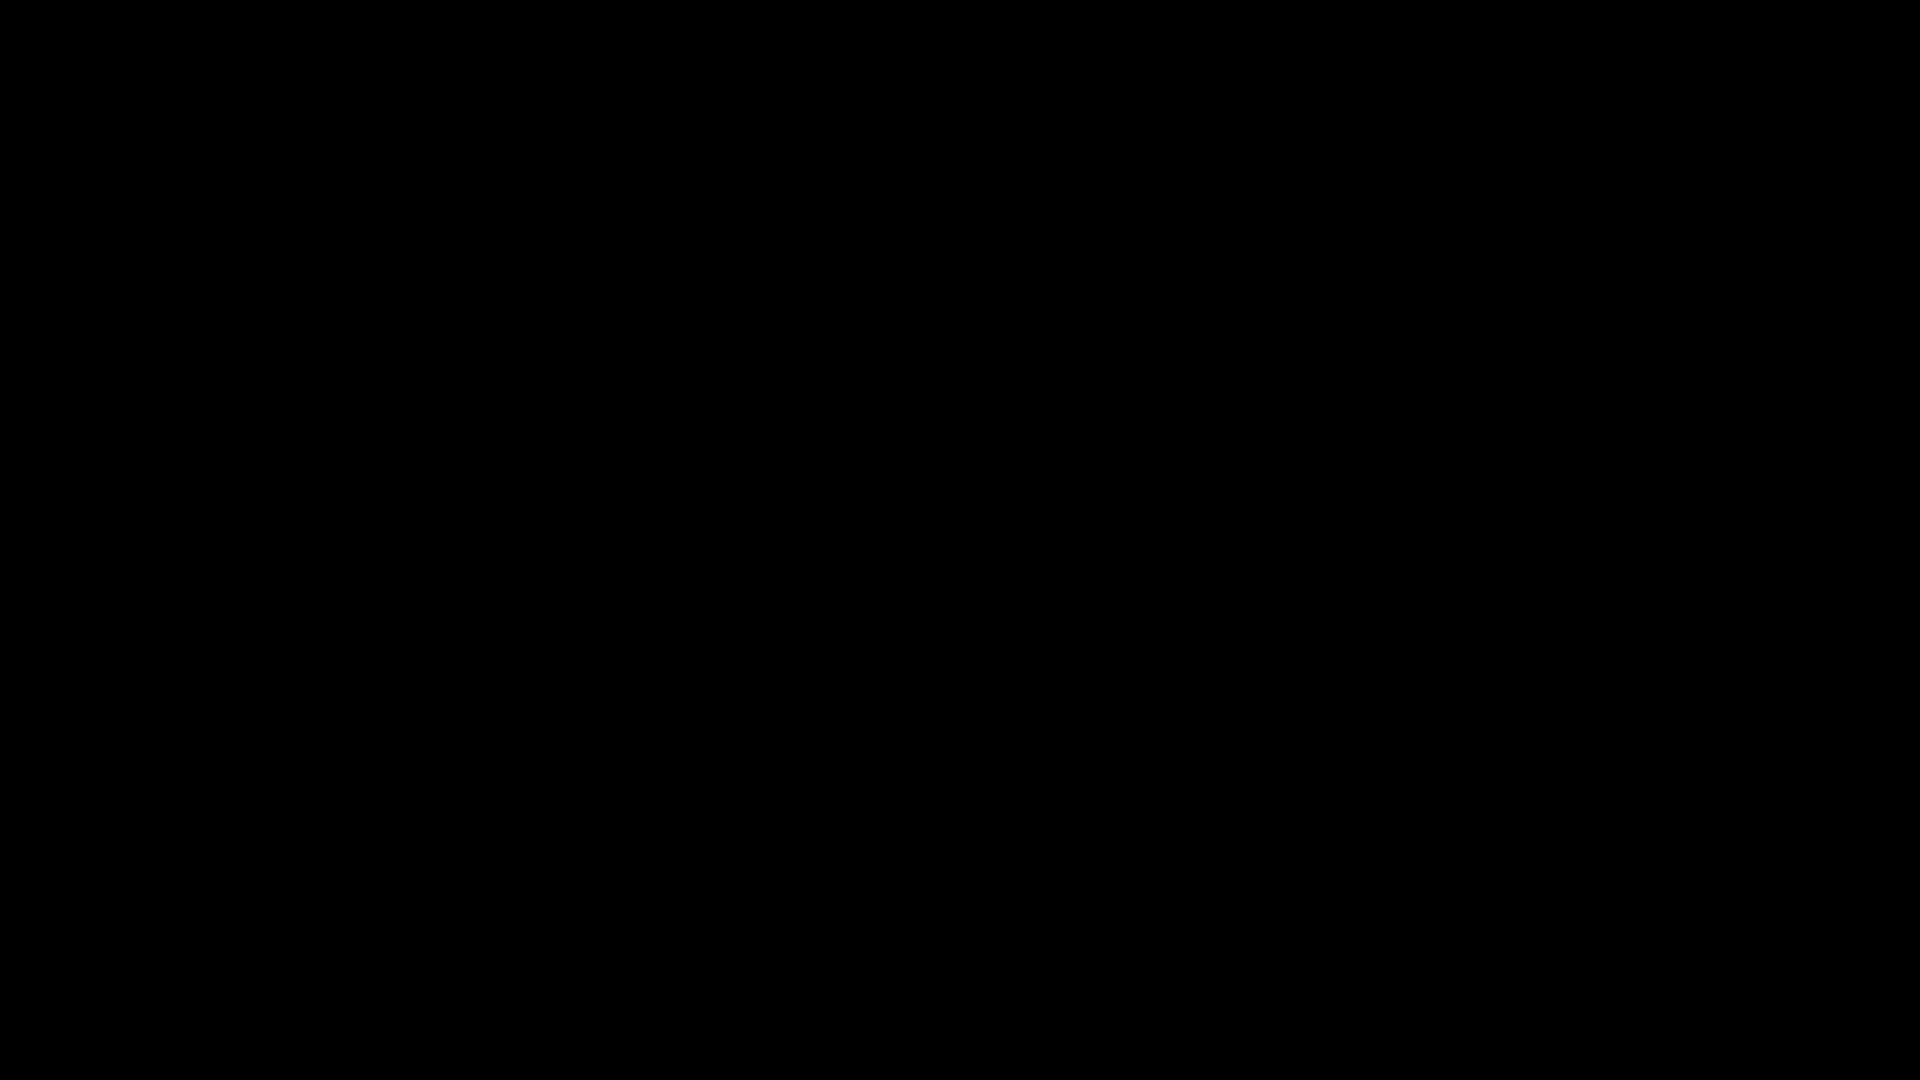

In [18]:
video_table.show()

In [19]:
video_table.add_column(audio_meta=get_metadata(video_table.audio))

Computing cells: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 315.96 cells/s]
Added 1 column value with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=1, num_excs=0, updated_cols=[], cols_with_excs=[])

video,audio,audio_meta
,,"{'size': 8266796, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 7290936576, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 516.648}], 'bit_rate': 128006, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"

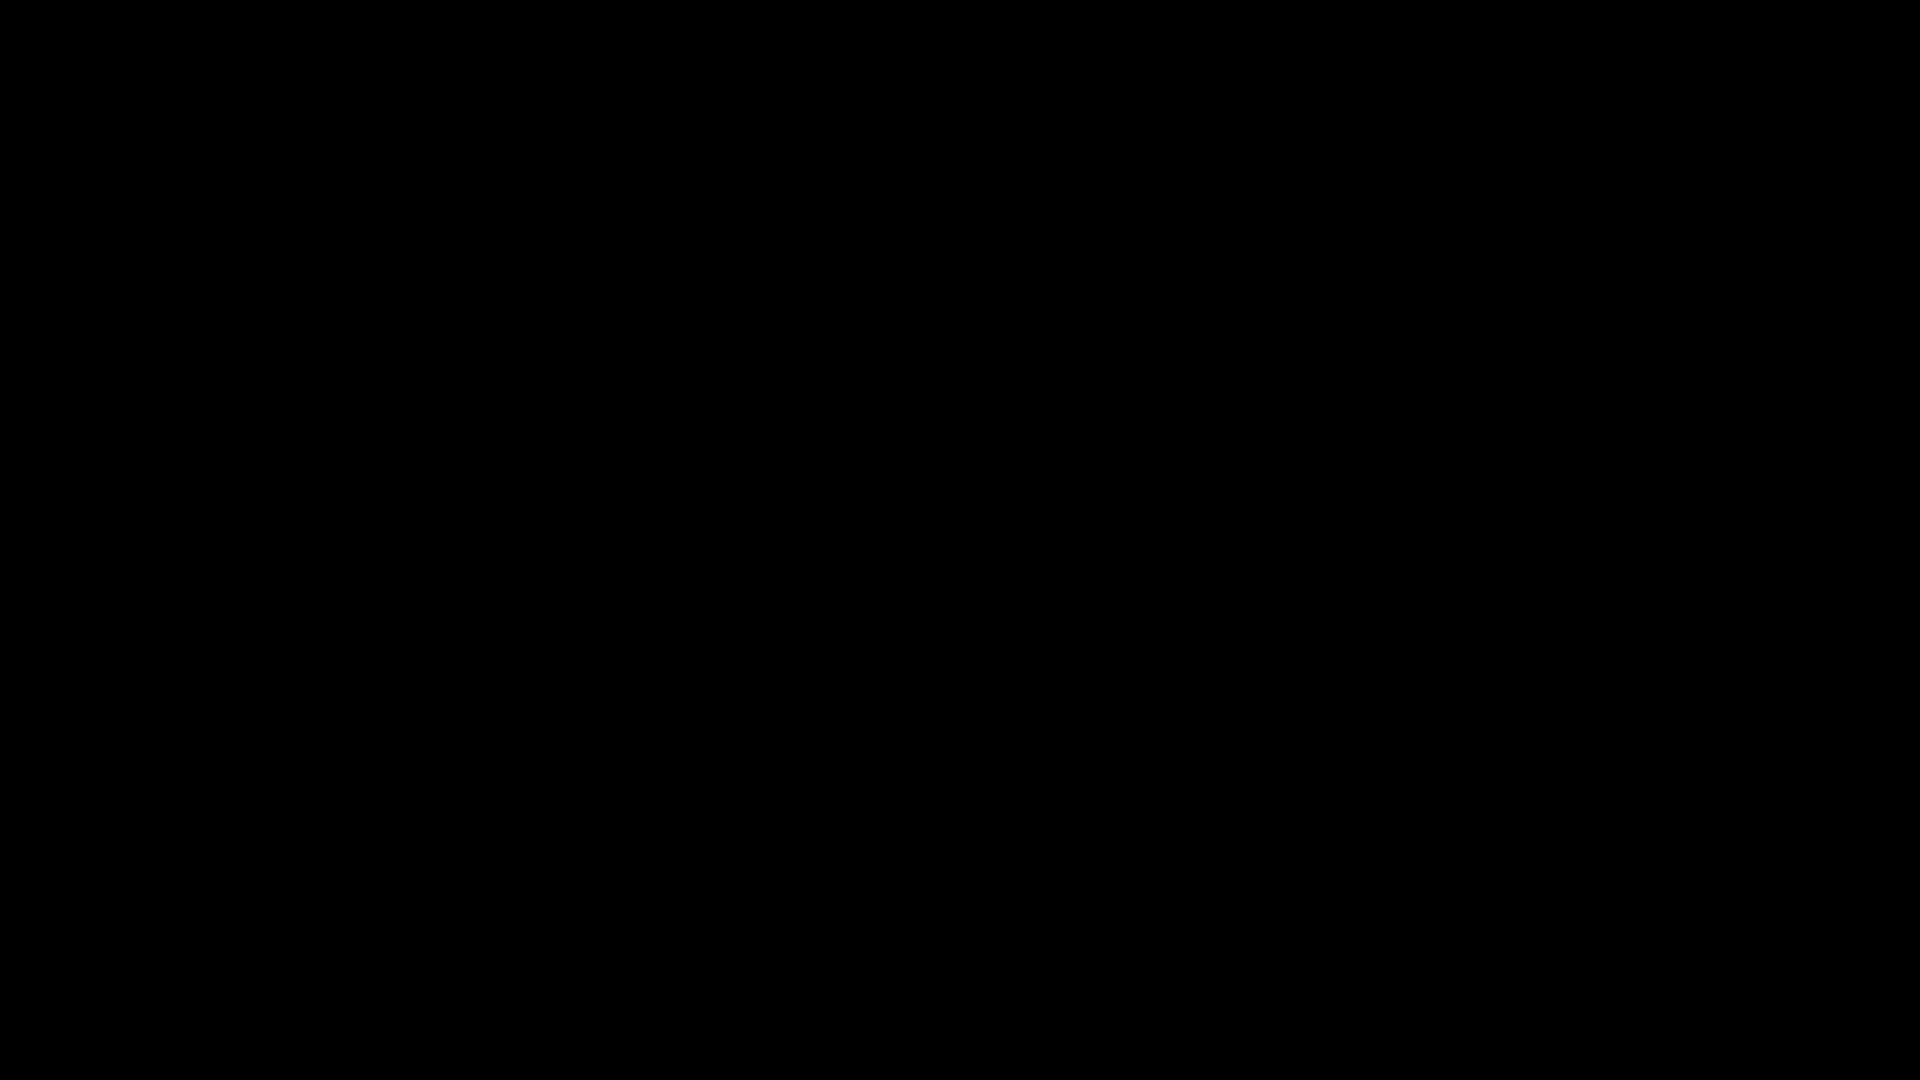

In [20]:
video_table.show()

In [21]:
video_table.add_column(transcription=openai.transcriptions(audio=video_table.audio, model='whisper-1'))

Computing cells: 100%|████████████████████████████████████████████| 1/1 [00:23<00:00, 23.43s/ cells]
Added 1 column value with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=1, num_excs=0, updated_cols=[], cols_with_excs=[])

video  \
0  /Users/orm/repos/pixeltable/docs/drafts/whispe...   

                                               audio  \
0  /Users/orm/.pixeltable/media/f8cb59561806456f8...   

                                          audio_meta  \
0  {'size': 8266796, 'streams': [{'type': 'audio'...   

                                       transcription  \
0  {'text': 'The Snowflake back on track after a ...   

                                  transcription_text  
0  The Snowflake back on track after a couple of ...
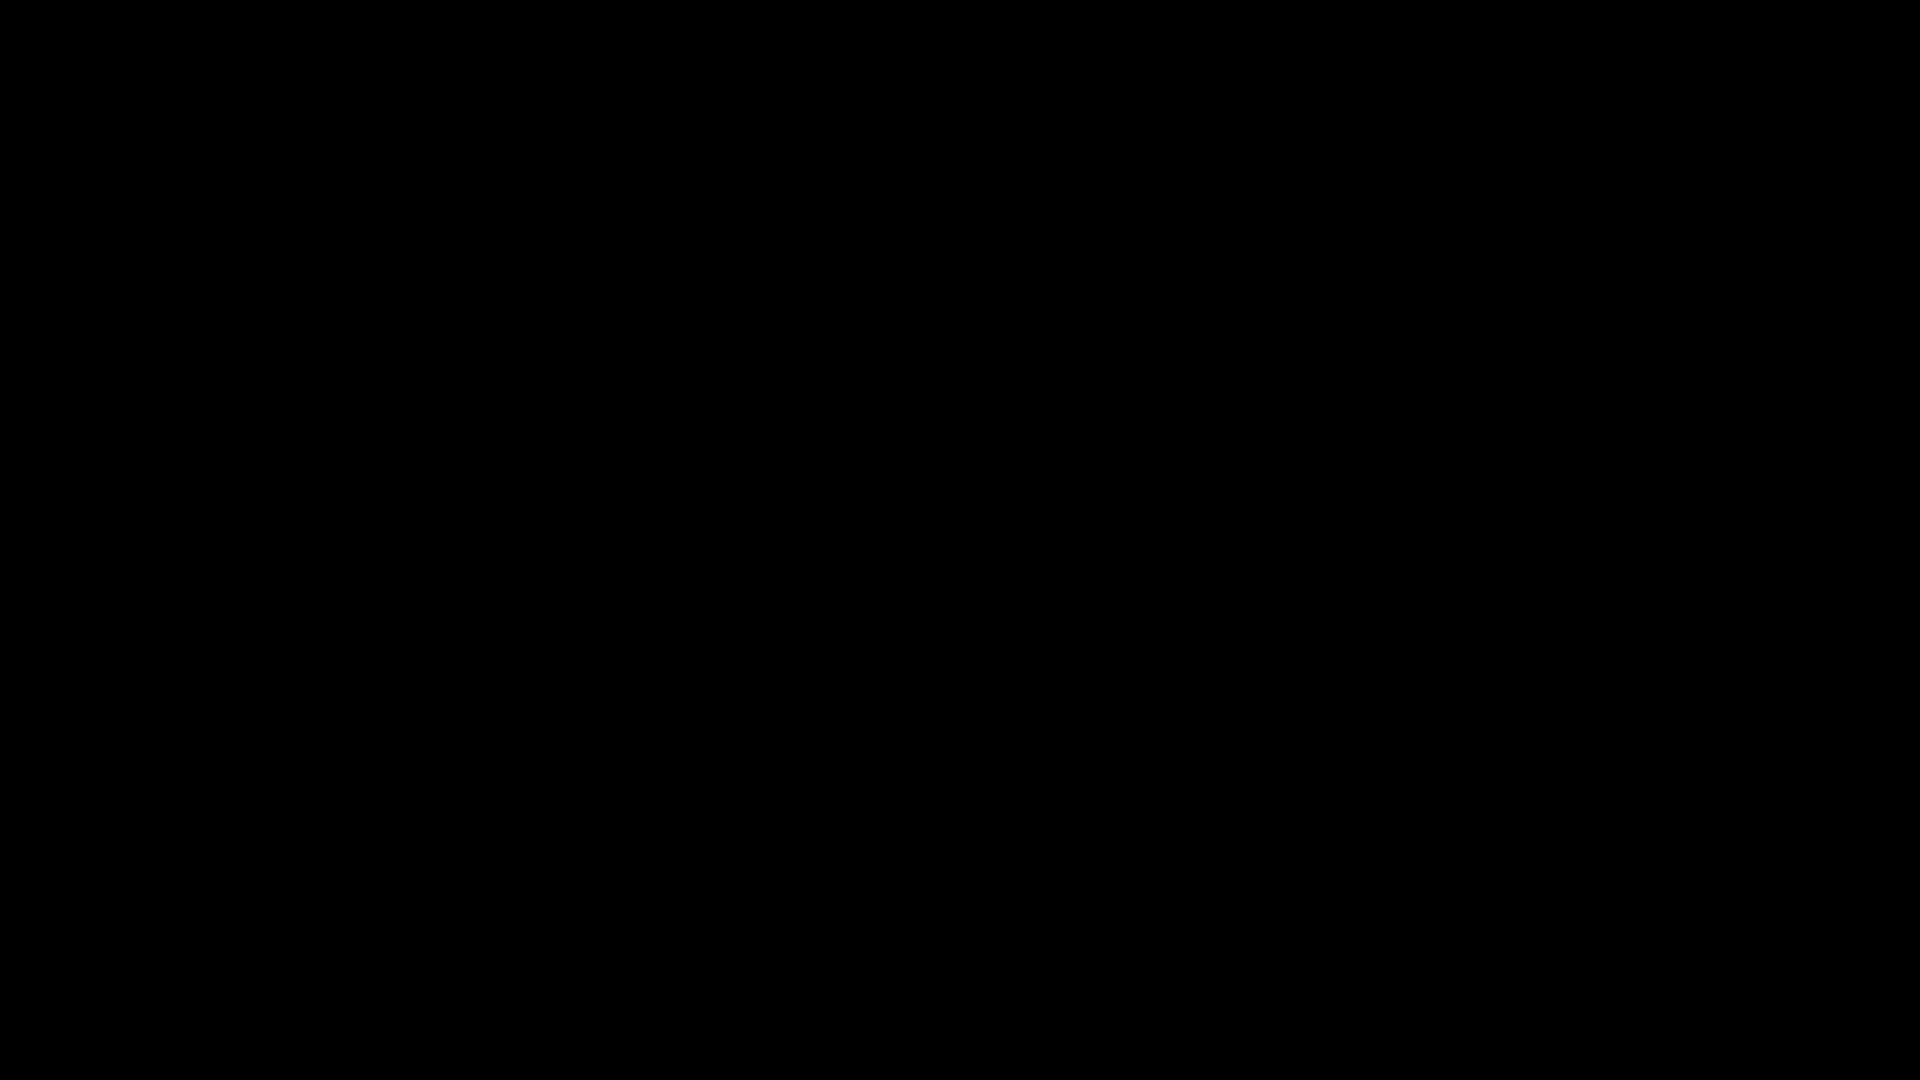

In [24]:
video_table.show()

In [27]:
video_table.add_column(transcription_text=video_table.transcription.text)

Computing cells: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 244.10 cells/s]
Added 1 column value with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=1, num_excs=0, updated_cols=[], cols_with_excs=[])

In [38]:
import embeddings
import importlib
importlib.reload(embeddings)
from embeddings import TextSplitter, e5_embed

In [36]:
sentence_view = pxt.create_view('transcription_demo.sentence_view',
                                video_table,
                                iterator=TextSplitter.create(text=video_table.transcription_text))

Inserting rows into `sentence_view`: 131 rows [00:00, 12150.95 rows/s]
Created view `sentence_view` with 131 rows, 0 exceptions.


In [37]:
sentence_view.select(sentence_view.pos, sentence_view.text).where(sentence_view.pos <= 10).show()

pos,text
0,The Snowflake back on track after a couple of months in the wilderness.
1,The last time we heard from this enterprise software data analytics companies back in February they put a strong quarter with a tepid four year forecast stock plunge from two hundred thirty down to the mid 100s.
2,Since then while many other tech names have rebounded like crazy stuff is only traded back up to 163 as of today's close.
3,But tonight these guys report tremendous core stuff like big expectations on every key line item for the quarter revenue product revenue operating income free cash flow.
4,You name it.
5,Take time as we gave a strong product revenue guidance for the current quarter and raise their full year product revenue forecast.
6,They gave you a little less a lower margin number but we'll find out about that.
7,So with the stock coming into the quarter cold these numbers were enough to send it higher.
8,And if you are just the beginning let's check in with Sridhar Ramaswamy.
9,He is the new CEO of Snowflake.


In [39]:
sentence_view.add_embedding_index(col_name='text', text_embed=e5_embed)

Computing cells: 100%|████████████████████████████████████████| 131/131 [00:03<00:00, 39.08 cells/s]


In [42]:
similarity = sentence_view.text.similarity('you should buy NVIDIA')
sentence_view.select(sentence_view.text, similarity).order_by(similarity, asc=False).limit(20).collect()

text,col_1
To make you money.,0.835868
Now all this actual macro activity is vying for headlines with Nvidia.,0.824716
My wife wants to buy one.,0.818205
You still want to make sure that the applications working well or you want to try out a new model.,0.817813
Our foundation model Arctic was unsurprisingly done on top of Nvidia chips.,0.814672
Follow at Jim Cramer on X. Have a question.,0.812509
Follow at Jim Cramer on X. Have a question.,0.812509
Let's talk about GPU because you've got your June 3rd to 6th data cloud summit.,0.812478
Welcome to Mad Money.,0.812043
Head to mad money dot CNBC dot com.,0.810483


In [41]:
video_table.insert([{'video': video_path} for video_path in paths[2:]])

Inserting rows into `video_table`: 1 rows [00:00, 120.76 rows/s]██| 5/5 [00:43<00:00,  8.68s/ cells]
Computing cells: 100%|████████████████████████████████████████████| 5/5 [00:43<00:00,  8.69s/ cells]
Inserting rows into `sentence_view`: 240 rows [00:00, 446.46 rows/s]
Inserted 241 rows with 0 errors.


UpdateStatus(num_rows=241, num_computed_values=5, num_excs=0, updated_cols=[], cols_with_excs=[])

video,audio,audio_meta
,,"{'size': 8266796, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 7290936576, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 516.648}], 'bit_rate': 128006, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"
,,"{'size': 9245228, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 8153913600, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 577.8}], 'bit_rate': 128005, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"
,,"{'size': 10607276, 'streams': [{'type': 'audio', 'frames': 0, 'duration': 9355239936, 'metadata': {'encoder': 'Lavf'}, 'time_base': '1/14112000', 'codec_context': {'name': 'mp3float', 'profile': None, 'channels': 2, 'codec_tag': '\\x00\\x00\\x00\\x00'}, 'duration_seconds': 662.928}], 'bit_rate': 128005, 'metadata': {'encoder': 'Lavf60.3.100'}, 'bit_exact': False}"

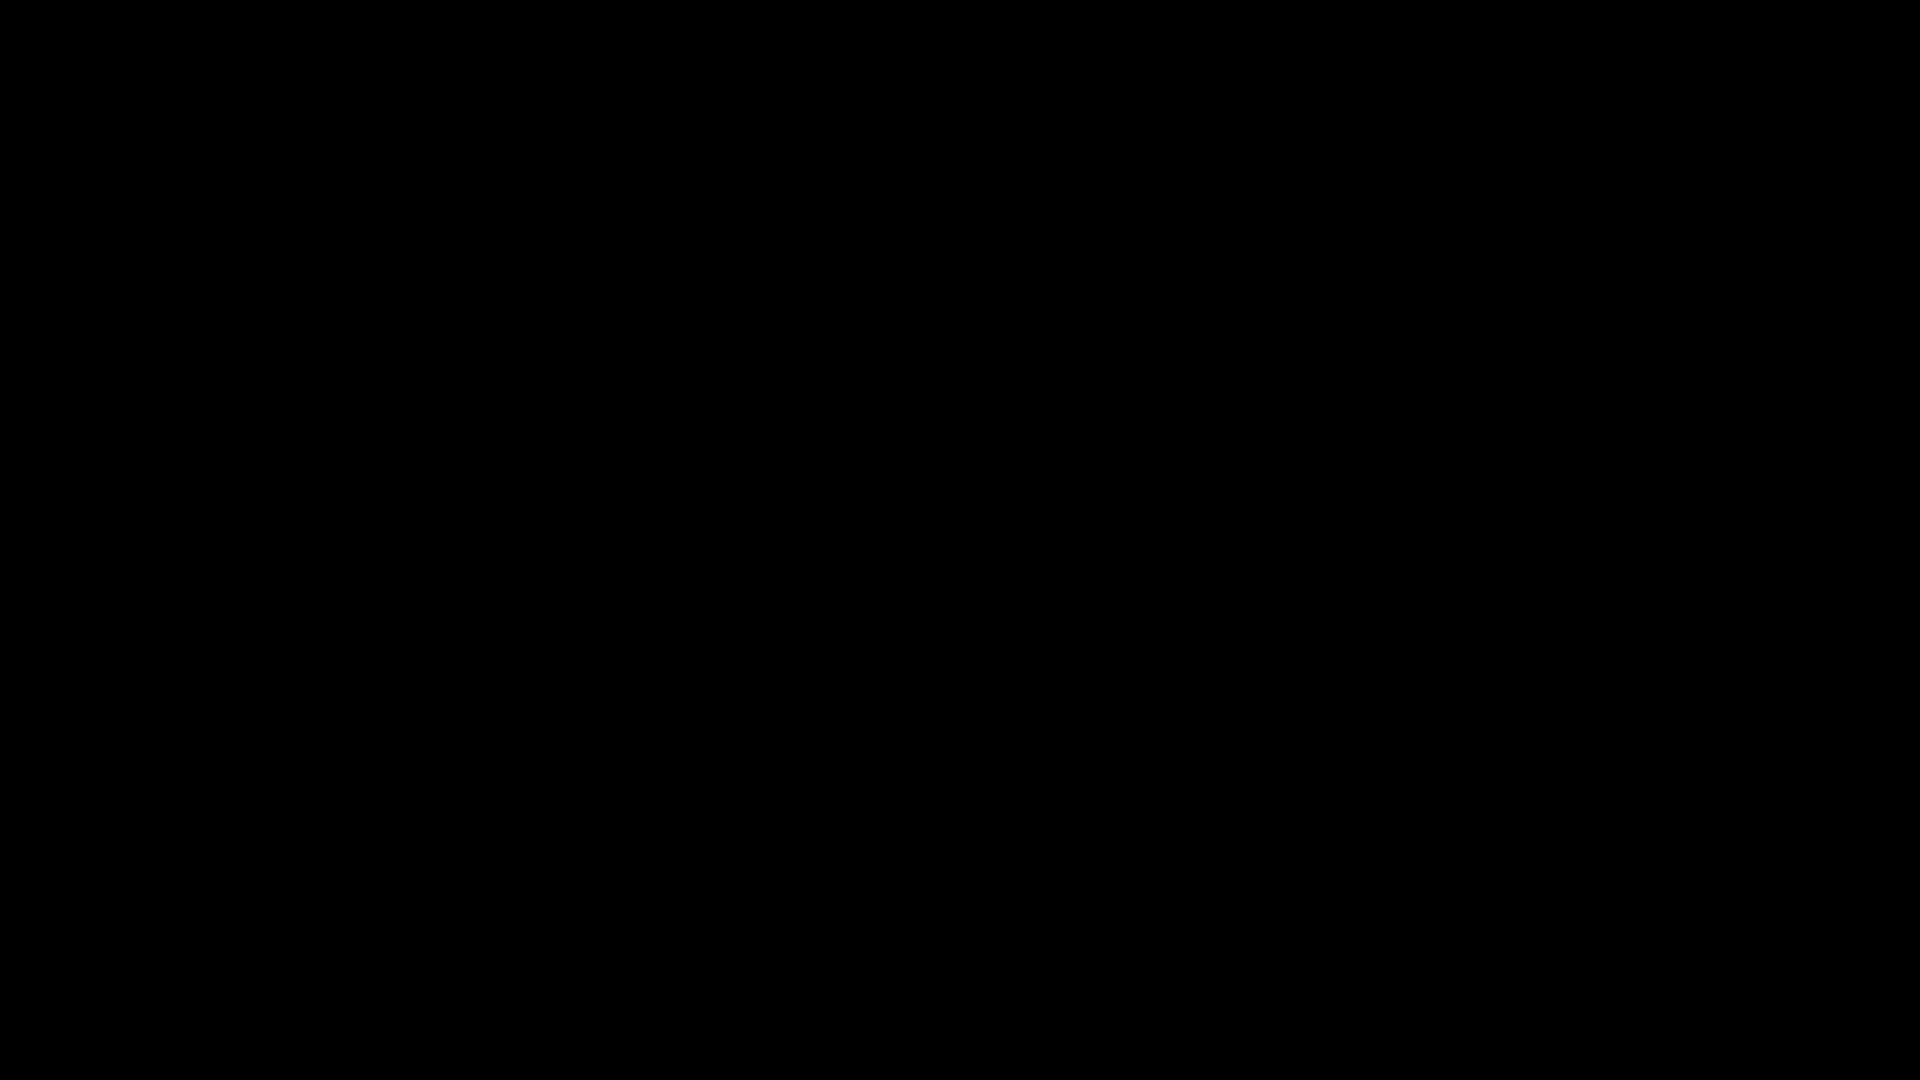
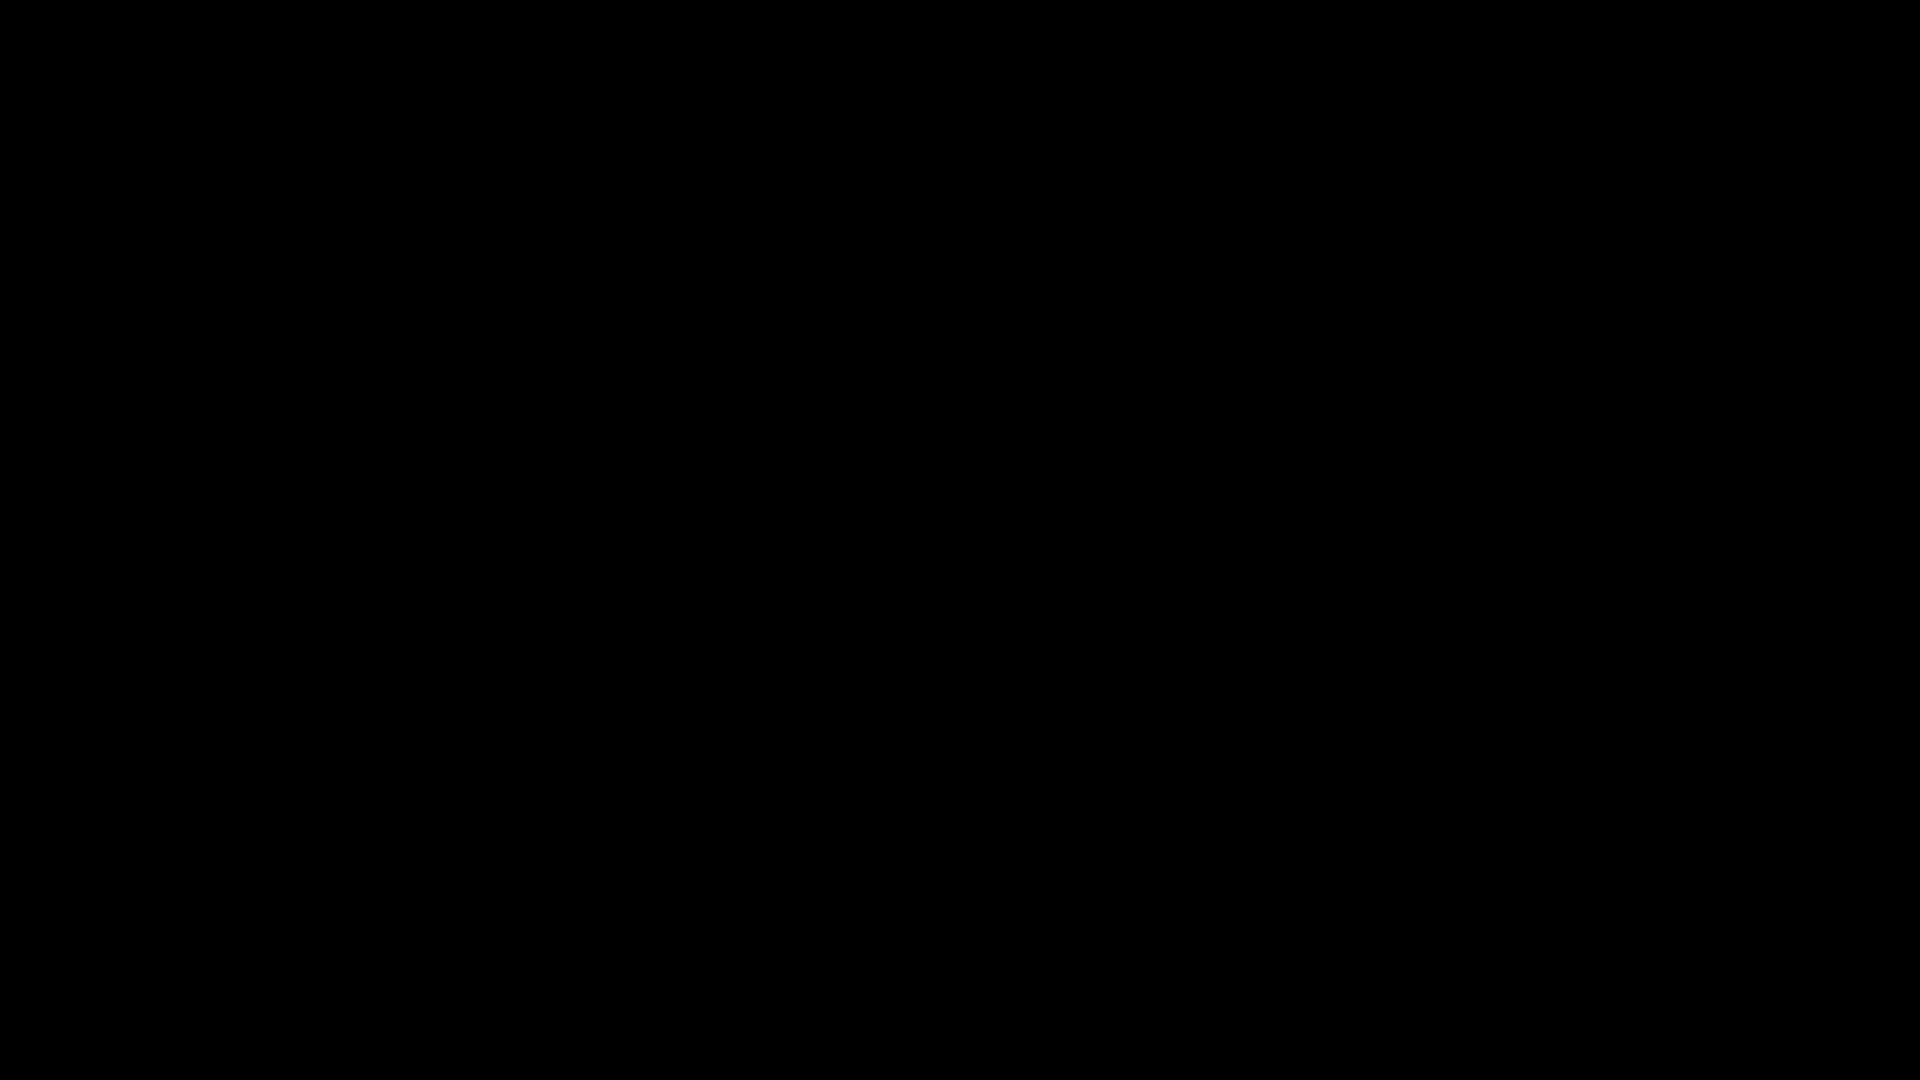
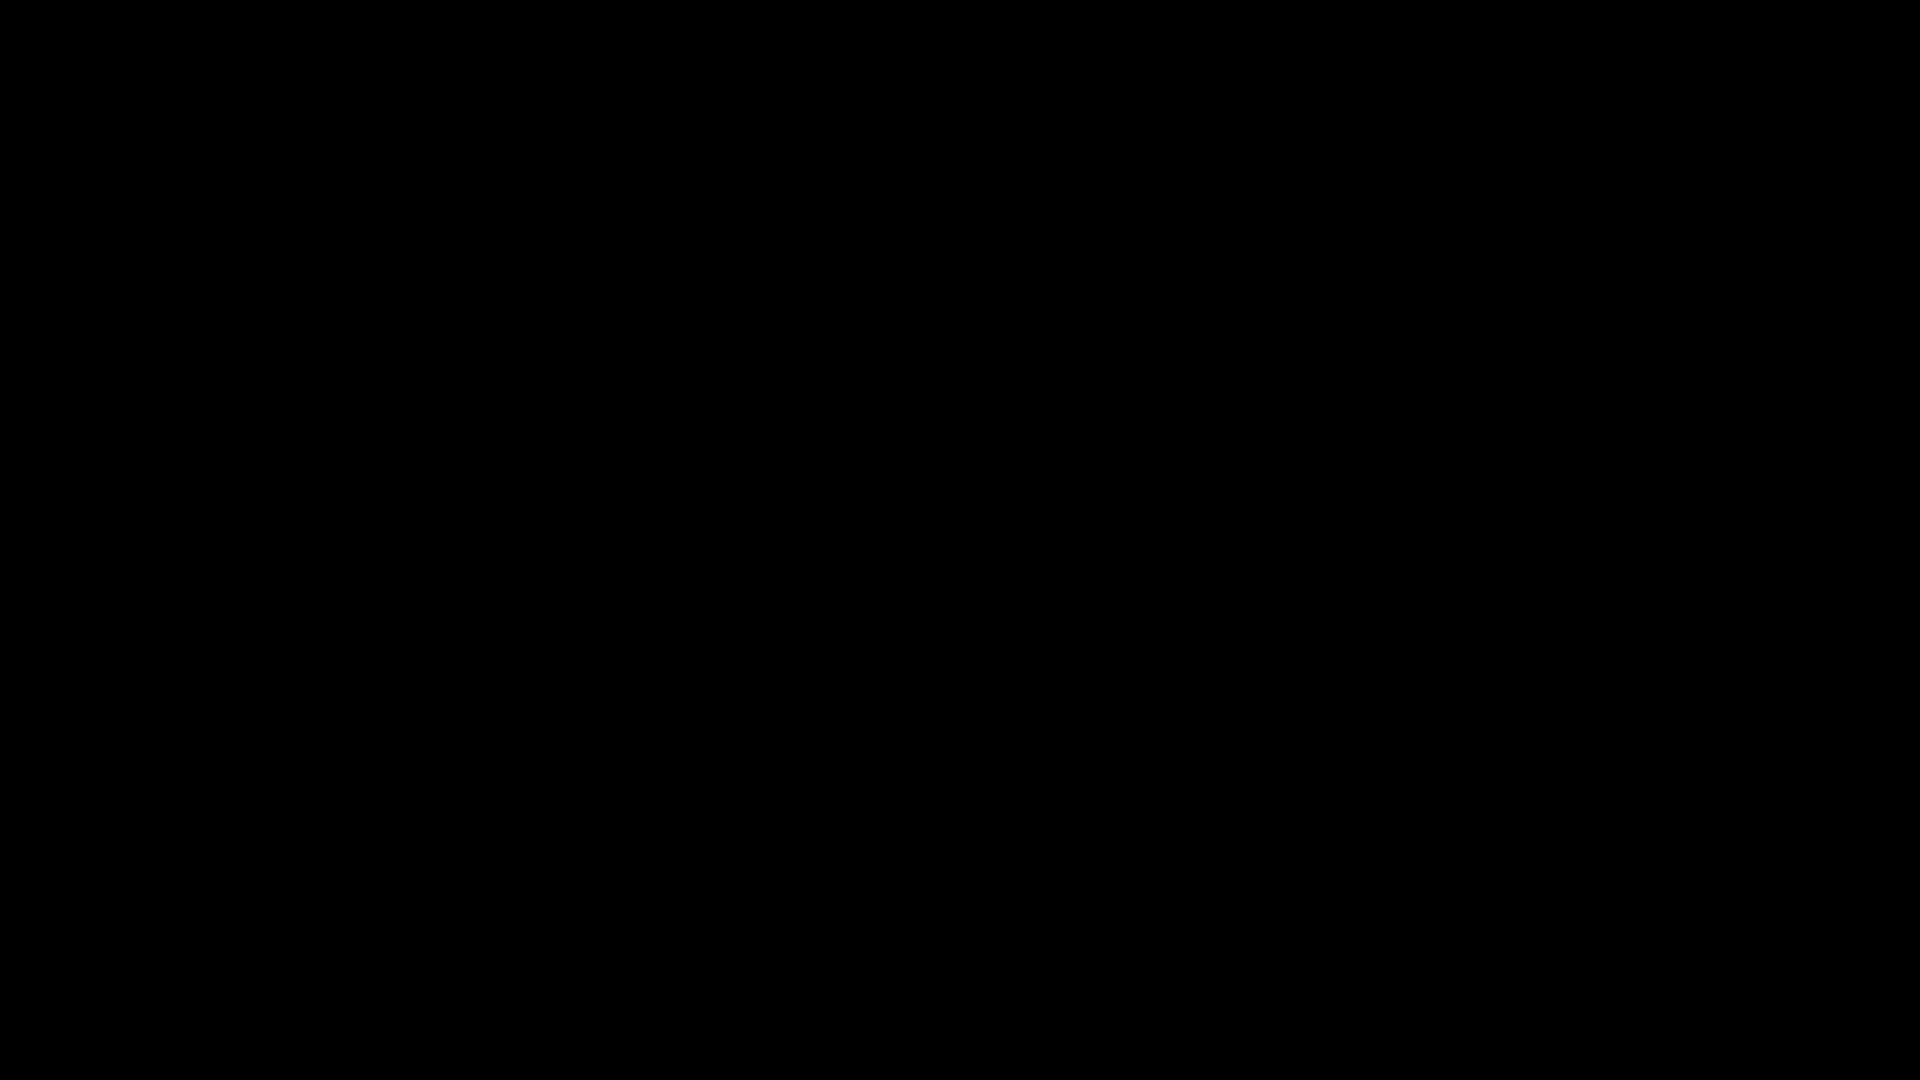

In [21]:
video_table.select(video_table.video, video_table.audio, video_table.audio_meta).show()